In [121]:
from dgl import model_zoo
import torch
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from dgl.data.chem.utils import smile2graph
import dgl
import torch

In [122]:
model = model_zoo.chem.load_pretrained("GCN_Tox21")
model.eval()
model

Loading pretrained model...


GCNClassifier(
  (gcn_layers): ModuleList(
    (0): GCNLayer(
      (graph_conv): GraphConv(in=74, out=64, normalization=False, activation=<function relu at 0x7f4a95c05620>)
      (dropout): Dropout(p=0.0)
      (res_connection): Linear(in_features=74, out_features=64, bias=True)
      (bn_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): GCNLayer(
      (graph_conv): GraphConv(in=64, out=64, normalization=False, activation=<function relu at 0x7f4a95c05620>)
      (dropout): Dropout(p=0.0)
      (res_connection): Linear(in_features=64, out_features=64, bias=True)
      (bn_layer): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (atom_weighting): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (soft_classifier): MLPBinaryClassifier(
    (predict): Sequential(
      (0): Dropout(p=0.0)
      (1): Linear(in_features=128, out_features=64, bias=Tru

In [123]:
tasks = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase',
         'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE',
         'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

In [124]:
smiles = "CC[NH+](CC)c1ccc(/C=C2\Oc3c(ccc(OCC(N)=O)c3C)C2=O)cc1"

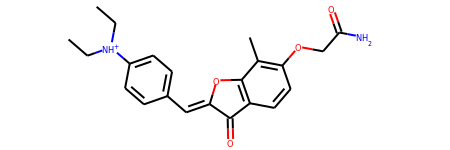

In [125]:
m = Chem.MolFromSmiles(smiles)
m

In [126]:
g = smile2graph(smiles)

In [127]:
g

DGLGraph(num_nodes=28, num_edges=60,
         ndata_schemes={'h': Scheme(shape=(74,), dtype=torch.float32)}
         edata_schemes={})

In [128]:
bg = dgl.batch([g])

In [129]:
e_importance = torch.ones((bg.number_of_edges(), 1)).requires_grad_(True)
n_importance = bg.ndata['h'].requires_grad_(True)

In [130]:
bg.edata['es'] = e_importance

In [131]:
logits = model(n_importance, bg)

/home/ubuntu/playground/mz_dgl/python/dgl/base.py:18: UserWarning: Initializer is not set. Use zero initializer instead. To suppress this warning, use `set_initializer` to explicitly specify which initializer to use.
  warnings.warn(msg, warn_type)


In [132]:
logits[0][0].backward()

In [133]:
n_importance.grad

tensor([[ 0.0383,  0.0490, -0.0914,  ...,  0.1187, -0.1259, -0.0353],
        [-0.0565,  0.1625, -0.0234,  ..., -0.0053, -0.1274,  0.0440],
        [ 0.1063,  0.0213, -0.0479,  ...,  0.0749, -0.1954,  0.0414],
        ...,
        [-0.1190,  0.0717,  0.1063,  ...,  0.1576, -0.1782,  0.1545],
        [ 0.1897, -0.0728, -0.0280,  ...,  0.2411, -0.1603,  0.1072],
        [ 0.3061, -0.1738, -0.2959,  ...,  0.1522, -0.0324, -0.0848]])

In [134]:
n_grad = n_importance.grad.norm(dim=1)
n_grad = n_grad / n_grad.max()
e_grad = e_importance.grad/e_importance.grad.abs().max()

In [135]:
n_score = (n_importance*n_importance.grad).sum(1)
n_score = n_score/n_score.abs().max()

In [136]:
n_score

tensor([-0.0604, -0.2227, -0.0572,  0.2393,  0.1090,  0.2088,  0.2111,  0.1118,
        -0.0602, -0.0869, -0.2028,  0.1405,  0.1608,  0.2599,  0.6002,  0.0745,
        -0.3209,  0.4074,  0.3659, -0.0462,  0.1294, -0.0619, -0.0663, -0.0950,
         1.0000,  0.2971,  0.5483,  0.6876], grad_fn=<DivBackward0>)

In [137]:
from matplotlib import cm

In [138]:
c(1)

(0.4154555940023068, 0.003690888119953864, 0.12341407151095732, 1.0)

In [139]:
from rdkit.Chem.Draw import rdMolDraw2D

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D


In [140]:
def draw1():
    highlightAtomColors={}
    highlightBondColors={}
    
    c=cm.get_cmap("RdBu")
    
    for idx,w in enumerate(n_score):
        highlightAtomColors[idx]=c((w.data.numpy()+1)/2)[:3]
    
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
    drawer.DrawMolecule(m, highlightAtomColors=highlightAtomColors, highlightAtoms=list(highlightAtomColors.keys()), highlightBonds=[])
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    return svg

In [141]:
def draw2():
    highlightAtomColors={}
    highlightBondColors={}
    c=cm.get_cmap("Blues")
    
    for idx,w in enumerate(n_grad):
        highlightAtomColors[idx]=c((w.data.numpy()))[:3]
    
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
    drawer.DrawMolecule(m, highlightAtomColors=highlightAtomColors, highlightAtoms=list(highlightAtomColors.keys()), highlightBonds=[])
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    return svg

In [150]:
e_grad.shape

torch.Size([60, 1])

In [166]:
e_grad[:30]

tensor([[-0.1852],
        [ 0.1197],
        [-0.3167],
        [-0.1738],
        [-0.2134],
        [-0.3167],
        [ 0.0451],
        [-0.2247],
        [-0.0933],
        [ 0.1029],
        [ 0.0829],
        [-0.0709],
        [-0.1457],
        [-0.1331],
        [ 0.5913],
        [ 0.0349],
        [ 0.8031],
        [ 0.7203],
        [ 0.8111],
        [ 0.7693],
        [ 0.6257],
        [ 1.0000],
        [ 0.1902],
        [ 0.6385],
        [ 0.4854],
        [ 0.5245],
        [ 0.2747],
        [ 0.0428],
        [-0.1192],
        [ 0.1736]])

In [198]:
def draw3():
    highlightAtomColors={}
    highlightBondColors={}
    
    c=cm.get_cmap("RdBu")
    e_s=(e_grad.squeeze()[::2]+e_grad.squeeze()[1::2])/2
    
    for idx,w in enumerate(e_s):
        highlightBondColors[idx]=c((w.item()+1)/2)[:3]
    
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
    drawer.DrawMolecule(m, highlightAtoms=[],highlightBondColors=highlightBondColors, highlightBonds=list(highlightBondColors.keys()))
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    return svg

def draw4():
    highlightAtomColors={}
    highlightBondColors={}
    
    c=cm.get_cmap("RdBu")
    e_s=(e_grad.squeeze()[::2]+e_grad.squeeze()[1::2])/2
    
    for idx,w in enumerate(n_score):
        highlightAtomColors[idx]=c((w.data.numpy()+1)/2)[:3]
    
    for idx,w in enumerate(e_s):
        highlightBondColors[idx]=c((w.item()+1)/2)[:3]
    
    rdDepictor.Compute2DCoords(m)
    drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
    drawer.DrawMolecule(m, highlightAtomColors=highlightAtomColors, highlightAtoms=list(highlightAtomColors.keys()),highlightBondColors=highlightBondColors, highlightBonds=list(highlightBondColors.keys()))
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    return svg

In [199]:
len(list(m.GetBonds()))

30

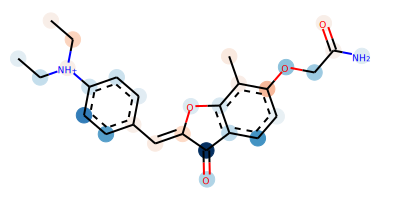

In [200]:
from IPython.display import SVG
SVG(draw1())

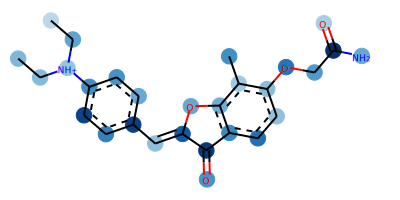

In [201]:
from IPython.display import SVG
SVG(draw2())

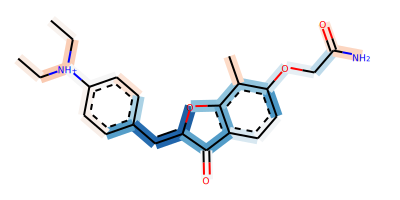

In [202]:
SVG(draw3())

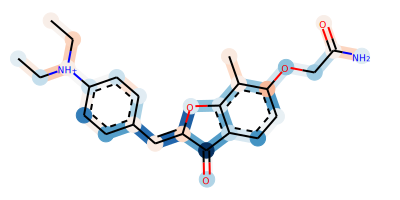

In [204]:
SVG(draw4())

In [203]:
preds = logits.data.numpy() > 0.5

In [68]:
import pandas as pd
pd.DataFrame(preds, columns=tasks)

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,False,False,True,False,True,False,True,False,True,False,False,True
